In [18]:
import dicom2nifti
import os 
import pydicom
import matplotlib.pyplot as plt
import SimpleITK as sitk
import numpy as np
from dcmrtstruct2nii import dcmrtstruct2nii, list_rt_structs
import shutil 

# Load reference image as nifti

In [17]:
base_folder = "/home/tachennf/Documents/delta-rad/madrid_study/data/Mont1/simu/"
output_file = "/home/tachennf/Documents/delta-rad/madrid_study/data/Mont1/nifti_simu/" + "simu.nii.gz"
def dicom_to_nifti(dicom_directory, output_file):
    # Read the DICOM series
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(dicom_directory)
    reader.SetFileNames(dicom_names)

    # Convert to a SimpleITK image
    image = reader.Execute()

    # Write the image as a NIfTI file
    sitk.WriteImage(image, output_file)
    print(f"Converted DICOM series to NIfTI: {output_file}")

dicom_to_nifti(base_folder, output_file)

Converted DICOM series to NIfTI: /home/tachennf/Documents/delta-rad/madrid_study/data/Mont1/nifti_simu/simu.nii.gz


# Load RT STRUCT

In [18]:
rt_struct_path = "/home/tachennf/Documents/delta-rad/madrid_study/data/Mont1/Montpellier_mont1_RTst_2024-07-11_110955_MRI.Study.from.2024-07-11.02.04_RTSTR_n1__00000/2.16.840.1.114362.1.12289667.27454039548.698351266.280.551.dcm"

rt_struct = pydicom.dcmread(rt_struct_path)
roi_names = [roi.ROIName for roi in rt_struct.StructureSetROISequence]
#for contour in rt_struct.ROIContourSequence:
print(rt_struct.ROIContourSequence[0].ContourSequence[0].ContourData)
# print(contour.ReferencedROINumber, contour.ContourSequence[0].ContourData)
# print(roi_names)
# print(rt_struct.StructureSetROISequence[0])

[13.4678, -62.9823, -130.7115, 14.9678, -62.9823, -130.7115, 16.4678, -62.9823, -130.7115, 17.9678, -62.9823, -130.7115, 19.4678, -62.9823, -130.7115, 20.9678, -62.9823, -130.7115, 22.4678, -62.9823, -130.7115, 23.9678, -62.9823, -130.7115, 25.4678, -62.9823, -130.7115, 26.9678, -62.9823, -130.7115, 28.4678, -62.9823, -130.7115, 29.9678, -62.9823, -130.7115, 31.4678, -62.9823, -130.7115, 32.9678, -62.9823, -130.7115, 34.4678, -62.9823, -130.7115, 35.9678, -62.9823, -130.7115, 37.4678, -62.9823, -130.7115, 38.9678, -62.9823, -130.7115, 40.4678, -62.9823, -130.7115, 41.9678, -62.9823, -130.7115, 43.4678, -62.9823, -130.7115, 44.9678, -62.9823, -130.7115, 46.4678, -62.9823, -130.7115, 47.9678, -62.9823, -130.7115, 49.4678, -62.9823, -130.7115, 50.9678, -62.9823, -130.7115, 52.4678, -62.9823, -130.7115, 53.9678, -62.9823, -130.7115, 55.4678, -62.9823, -130.7115, 55.4678, -62.9823, -130.7115, 56.9678, -61.4823, -130.7115, 58.4678, -61.4823, -130.7115, 59.9678, -61.4823, -130.7115, 61.4678, 

(332, 234, 88)
got ptv
0
0
0
0
0
0
0
0
0
0
0
0
0
3168
3168
3168
3168
3168
3168
3168
3168
3168
3168
3168
3168
3168
3168
3168
k:  88


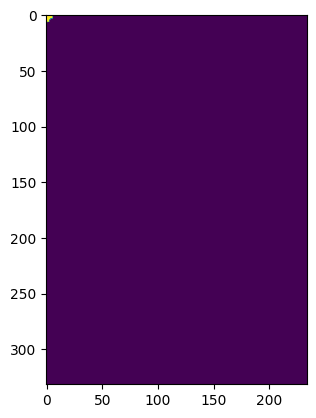

In [19]:
# Load the RT Struct file

# # Access basic information
# print(f"Modality: {rt_struct.Modality}")
# print(f"Number of Structures: {len(rt_struct.StructureSetROISequence)}")
# print(f"Patient Name: {rt_struct.StructureSetROISequence}")
# 
# Iterate over structuresimport pydicom
import numpy as np
import nibabel as nib
from scipy.ndimage import binary_fill_holes
from skimage.draw import polygon2mask

def contour_to_mask(contour_sequence, shape, slice_index):
    """
    Convert a single contour sequence to a binary mask.
    """
    for contour in contour_sequence:
        coordinates = contour.ContourData
        
        points = np.array(coordinates).reshape(-1, 3) # shape len(coordinates), 3 (x, y, z)
        poly_coords = points[:, :2]
        poly_coords = np.round(poly_coords).astype(int)

        mask = polygon2mask(shape, poly_coords)
        plt.imshow(mask)

        return mask
        

def rtstruct_to_nifti(rtstruct_path, reference_image_path, output_path):
    """
    Convert RT Struct contours to NIfTI masks.
    """
    rtstruct = pydicom.dcmread(rtstruct_path)
    reference_image = nib.load(reference_image_path)
    reference_data = reference_image.get_fdata()
    print(reference_data.shape)
    shape = reference_data.shape[:2]

    for roi in rtstruct.StructureSetROISequence:
        roi_name = roi.ROIName
        # print(f"Processing ROI: {roi_name}")

        # Create a 3D mask for the ROI
        if roi_name == 'PTV': 
            print('got ptv')
            mask_3d = np.zeros(reference_data.shape, dtype=np.uint8)
            k = 0 
            for contour in rtstruct.ROIContourSequence:
                if contour.ReferencedROINumber == roi.ROINumber:
                    for slice_index in range(reference_data.shape[2]):
                        mask_2d = contour_to_mask(contour.ContourSequence, shape, slice_index) # TODO: fix this 
                        if mask_2d is not None:
                            mask_3d[:, :, slice_index] = mask_2d
                            k += 1
                print(np.sum(mask_3d))

            # Save the mask as a NIfTI file
            nifti_mask = nib.Nifti1Image(mask_3d, reference_image.affine)
            nib.save(nifti_mask, f"{output_path}/{roi_name}.nii.gz")
            print("k: ", k)
# Example usage
rt_struct = pydicom.dcmread(rt_struct_path)

output_path = "/home/tachennf/Documents/delta-rad/madrid_study/data/Mont1/nifti_simu/"

rtstruct_to_nifti(rt_struct_path, output_file, output_path)


In [2]:
reader = sitk.ImageFileReader()
reader.SetFileName("/home/tachennf/Documents/delta-rad/madrid_study/data/Mont1/Montpellier_mont1_RTst_2024-07-11_110955_MRI.Study.from.2024-07-11.02.04_RTSTR_n1__00000/2.16.840.1.114362.1.12289667.27454039548.698351266.280.551.dcm")
reader.LoadPrivateTagsOn()
reader.ReadImageInformation()
for k in reader.GetMetaDataKeys():
    v = reader.GetMetaData(k)
    print(f'({k}) = = "{v}"')

RuntimeError: Exception thrown in SimpleITK ImageFileReader_ReadImageInformation: /tmp/SimpleITK/Code/IO/src/sitkImageReaderBase.cxx:99:
sitk::ERROR: Unable to determine ImageIO reader for "/home/tachennf/Documents/delta-rad/madrid_study/data/Mont1/Montpellier_mont1_RTst_2024-07-11_110955_MRI.Study.from.2024-07-11.02.04_RTSTR_n1__00000/2.16.840.1.114362.1.12289667.27454039548.698351266.280.551.dcm"

# DicomRTTool

In [25]:
from DicomRTTool.ReaderWriter import DicomReaderWriter, ROIAssociationClass
Dicom_path = "/home/tachennf/Documents/delta-rad/madrid_study/data/Mont1/Montpellier_mont1_RTst_2024-07-11_110955_MRI.Study.from.2024-07-11.02.04_RTSTR_n1__00000"
Dicom_reader = DicomReaderWriter(description='Examples', arg_max=True)
Dicom_reader.walk_through_folders(Dicom_path) # This will parse through all DICOM present in the folder and subfolders
Dicom_reader.get_images()
# all_rois = Dicom_reader.return_rois(print_rois=True) # Return a list of all rois present


Loading through DICOM files: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]

Loading from /home/tachennf/Documents/delta-rad/madrid_study/data/Mont1/Montpellier_mont1_RTst_2024-07-11_110955_MRI.Study.from.2024-07-11.02.04_RTSTR_n1__00000
Compiling dictionaries together...
Index 0, description None at None
1 unique series IDs were found. Default is index 0, to change use set_index(index)
This index does not have an associated image within the loaded folders


In [22]:
Contour_names = ['PTV'] # Define what rois you want
associations = [ROIAssociationClass('PTV', ['PTV'])] # Any list of roi associations
Dicom_reader.set_contour_names_and_assocations(Contour_names)
Dicom_reader.get_images_and_mask()


AttributeError: 'DicomReaderWriter' object has no attribute 'set_contour_names_and_assocations'

# dcmrtstruct2nii 

In [7]:
rt_struct_path = "/home/tachennf/Documents/delta-rad/madrid_study/data/Mont1/Montpellier_mont1_RTst_2024-07-11_110955_MRI.Study.from.2024-07-11.02.04_RTSTR_n1__00000/2.16.840.1.114362.1.12289667.27454039548.698351266.280.551.dcm"
output_path = "/home/tachennf/Documents/delta-rad/madrid_study/data/Mont1/nifti_simu/"
original_extracted_dicom = "/home/tachennf/Documents/delta-rad/madrid_study/data/Mont1/Montpellier_mont1_MR_2024-07-22_131350_Study-F0_TRUFI_n88__00000/"
print(list_rt_structs(rt_struct_path))
dcmrtstruct2nii(rt_struct_path, original_extracted_dicom, output_path, structures="GTV_5000_Tumor", mask_foreground_value=1)

['Skin', 'Aorta', 'Esophagus', 'Heart', 'KIDNEY_LEFT', 'KIDNEY_RIGHT', 'Liver', 'SPINAL_CORD', 'Spleen', 'Stomach', 'Bowel', 'Duodenum', 'GTV_5000_Tumor', 'PTV', 'MARGEN2CM', 'MARGEN4CM', 'MARGEN7CM', 'RF_4MENOS2', 'RF_7MENOS4', 'CRITSTRUCT', 'CRITIDF', 'CRITALL', 'PTV_HIGH', 'PTV_LOW', 'TRACKING', 'agua', 'aire', 'Isocenter']


# Organize folders 

In [ ]:
if os.path.exists("/home/tachennf/Documents/delta-rad/madrid_study/clean_data/") == False: 
    os.mkdir("/home/tachennf/Documents/delta-rad/madrid_study/clean_data/")

patients_list = os.listdir("/home/tachennf/Documents/delta-rad/madrid_study/Montpelier/")

for p in patients_list:
    print(p)
    patient_folder = "/home/tachennf/Documents/delta-rad/madrid_study/Montpelier/" + p + "/"
    # récupérer tous les folders (image, rtstruct, rtdose, rtplan)
    dicom_folders = [x for x in os.listdir(patient_folder) if "_MR_" in x]
    rt_struct_folders = [x for x in os.listdir(patient_folder) if "RTst" in x]
    rt_dose_folders = [x for x in os.listdir(patient_folder) if "RTDOSE" in x]
    rt_plan_folders = [x for x in os.listdir(patient_folder) if "RTPLAN" in x]

    if p == 'Mont16':
        # remove folder that contain "Pancreas2_n1__00000" in the name
        dicom_folders = [x for x in dicom_folders if "Pancreas2_n1__00000" not in x]
        rt_struct_folders = [x for x in rt_struct_folders if "Pancreas2_n1__00000" not in x]
        rt_dose_folders = [x for x in rt_dose_folders if "Pancreas2_n1__00000" not in x]
        rt_plan_folders = [x for x in rt_plan_folders if "Pancreas2_n1__00000" not in x]
        assert len(dicom_folders) == len(rt_struct_folders) == len(rt_dose_folders) == len(rt_plan_folders), "Different number of folders"

    # récupérer les numéros de série 
    series = []
    for i in range(len(dicom_folders)):
        dicom_folder = patient_folder + dicom_folders[i]
        dicom_path = dicom_folder + '/' + os.listdir(dicom_folder)[0]
        dicom_data = pydicom.dcmread(dicom_path)
        series.append(dicom_data.StudyDate) #  SeriesInstanceUID
        
    # creer un dossier pour chaque patient dans clean_data
    if os.path.exists("/home/tachennf/Documents/delta-rad/madrid_study/clean_data/" + p) == False:
        os.mkdir("/home/tachennf/Documents/delta-rad/madrid_study/clean_data/" + p)
    for i in range(len(series)):
        if os.path.exists("/home/tachennf/Documents/delta-rad/madrid_study/clean_data/" + p + "/" + series[i]) == False:
            os.mkdir("/home/tachennf/Documents/delta-rad/madrid_study/clean_data/" + p + "/" + series[i]) # creer un dossier pour chaque série
        dicom_folder = patient_folder + dicom_folders[i]
        rt_struct_folder = patient_folder + rt_struct_folders[i]
        rt_dose_folder = patient_folder + rt_dose_folders[i]
        rt_plan_folder = patient_folder + rt_plan_folders[i]
#  
        # # creer un dossier pour chaque modalité 
        if os.path.exists("/home/tachennf/Documents/delta-rad/madrid_study/clean_data/" + p + "/" + series[i] + "/image") == False:
            os.mkdir("/home/tachennf/Documents/delta-rad/madrid_study/clean_data/" + p + "/" + series[i] + "/image")
        if os.path.exists("/home/tachennf/Documents/delta-rad/madrid_study/clean_data/" + p + "/" + series[i] + "/rt_struct") == False:
            os.mkdir("/home/tachennf/Documents/delta-rad/madrid_study/clean_data/" + p + "/" + series[i] + "/rt_struct")
        if os.path.exists("/home/tachennf/Documents/delta-rad/madrid_study/clean_data/" + p + "/" + series[i] + "/rt_dose") == False:
            os.mkdir("/home/tachennf/Documents/delta-rad/madrid_study/clean_data/" + p + "/" + series[i] + "/rt_dose")
        if os.path.exists("/home/tachennf/Documents/delta-rad/madrid_study/clean_data/" + p + "/" + series[i] + "/rt_plan") == False:
            os.mkdir("/home/tachennf/Documents/delta-rad/madrid_study/clean_data/" + p + "/" + series[i] + "/rt_plan")
        #     
        # copier les dicom depuis l'ancien dossier vers le nouveau 
        for file in os.listdir(dicom_folder):
            shutil.copy(dicom_folder + '/' + file, "/home/tachennf/Documents/delta-rad/madrid_study/clean_data/" + p + "/" + series[i] + "/image") 
        # copier les rtstruct depuis l'ancien dossier vers le nouveau
        for file in os.listdir(rt_struct_folder):
            shutil.copy(rt_struct_folder + '/' + file, "/home/tachennf/Documents/delta-rad/madrid_study/clean_data/" + p + "/" + series[i] + "/rt_struct") 
        # copier les rtdose depuis l'ancien dossier vers le nouveau
        for file in os.listdir(rt_dose_folder):
            shutil.copy(rt_dose_folder + '/' + file, "/home/tachennf/Documents/delta-rad/madrid_study/clean_data/" + p + "/" + series[i] + "/rt_dose")
        # copier les rtplan depuis l'ancien dossier vers le nouveau
        for file in os.listdir(rt_plan_folder):
            shutil.copy(rt_plan_folder + '/' + file, "/home/tachennf/Documents/delta-rad/madrid_study/clean_data/" + p + "/" + series[i] + "/rt_plan")


Mont16


Organiser dossier en: 
patients 
    date 
        image
        rt_dose 
        rt_struct 
        rt_plan

# Convert image and rt_struct to nifti

In [51]:
clean_data_folder = "/home/tachennf/Documents/delta-rad/madrid_study/clean_data/"
nifti_folder = "/home/tachennf/Documents/delta-rad/madrid_study/nifti_data/"

if os.path.exists(nifti_folder) == False: 
    os.mkdir(nifti_folder)

patients_list = os.listdir(clean_data_folder)
structure_count = {}

for p in patients_list: 
    if os.path.exists(nifti_folder + p) == False: 
        os.mkdir(nifti_folder + p)
    series = os.listdir(clean_data_folder + p)
    for s in series: 
        if os.path.exists(nifti_folder + p + '/' + s) == False: 
            os.mkdir(nifti_folder + p + '/' + s)
        image_folder = clean_data_folder + p + '/' + s + '/image/'
        rt_struct_folder = clean_data_folder + p + '/' + s + '/rt_struct/'

        rt_struct_path = rt_struct_folder + os.listdir(rt_struct_folder)[0]
        list_rt_struct = list_rt_structs(rt_struct_path)

        # for structure in list_rt_struct: 
        #     if structure in structure_count: 
        #         structure_count[structure] += 1
        #     else: 
        #         structure_count[structure] = 1


        structures = []
        if "GTV" in list_rt_struct: 
            structures.append("GTV")
        if "GTV_5000_Tumor" in list_rt_struct:
            structures.append("GTV_5000_Tumor")
        if "GTV40" in list_rt_struct:
            structures.append("GTV40")
        if "PTV" in list_rt_struct: 
            structures.append("PTV")
        if "PTV30" in list_rt_struct:
            structures.append("PTV30")
# 
        if len(structures) != 2: 
            print(p, list_rt_struct)
            continue 
# 
        output_path = nifti_folder + p + '/' + s + '/'
        dcmrtstruct2nii(rt_struct_path, image_folder, output_path, structures=structures, mask_foreground_value=1)
# 
        if "GTV_5000_Tumor" in structures: 
            # rename nifti file 
            os.rename(output_path + "mask_GTV_5000_Tumor.nii.gz", output_path + "mask_GTV.nii.gz")
        if "GTV40" in structures: 
            # rename nifti file 
            os.rename(output_path + "mask_GTV40.nii.gz", output_path + "mask_GTV.nii.gz")
        if "PTV30" in structures: 
            # rename nifti file 
            os.rename(output_path + "mask_PTV30.nii.gz", output_path + "mask_PTV.nii.gz")

Mont2 ['Skin', 'Agua', 'Aire', 'Aorta', 'Bowel', 'CTV35', 'CRITIDF', 'CRITSTRUCT', 'Duodenum', 'Esophagus', 'GTV40', 'Heart', 'KIDNEY_LEFT', 'KIDNEY_RIGHT', 'Liver', 'MARGEN2CM', 'MARGEN4CM', 'MARGEN7CM', 'MARGENPTV40_06', 'PTV35', 'PTV35_HIGH', 'PTV35_LOW', 'PTV40', 'PTV40_HIGH', 'PTV40_LOW', 'RF_PTV35', 'RF_4MENOS2', 'RF_7MENOS4', 'SPINAL_CORD', 'Spleen', 'Stomach', 'Isocenter']
Mont2 ['Skin', 'Agua', 'Aire', 'Aorta', 'Bowel', 'CTV35', 'CRITIDF', 'CRITSTRUCT', 'Duodenum', 'Esophagus', 'GTV40', 'Heart', 'KIDNEY_LEFT', 'KIDNEY_RIGHT', 'Liver', 'MARGEN2CM', 'MARGEN4CM', 'MARGEN7CM', 'MARGENPTV40_06', 'PTV35', 'PTV35_HIGH', 'PTV35_LOW', 'PTV40', 'PTV40_HIGH', 'PTV40_LOW', 'RF_PTV35', 'RF_4MENOS2', 'RF_7MENOS4', 'SPINAL_CORD', 'Spleen', 'Stomach', 'Isocenter']
Mont2 ['Skin', 'Agua', 'Aire', 'Aorta', 'Bowel', 'CTV35', 'CRITIDF', 'CRITSTRUCT', 'Duodenum', 'Esophagus', 'GTV40', 'Heart', 'KIDNEY_LEFT', 'KIDNEY_RIGHT', 'Liver', 'MARGEN2CM', 'MARGEN4CM', 'MARGEN7CM', 'MARGENPTV40_06', 'PTV35', 

Mont2: GTV40, PTV40 \
Mont13: CTV, PTV \
Mont4: CTV45, PTV \
Mont29: GTV, PTV40 or PTV50 \
Mont19: GTV1, PTV1 \
Mont31: CTV_5000_Tumor, PTV50TUMOR \
Mont37: CTV_50, PTV \
Mont5: CTV_4500_Tumor, PTV \
Mont25: CTV 50, PTV50 \
Mont3: GTV45, PTV \
Mont30: GTV40, PTV35 \
Mont36: CTV, PTV \